## **README**
  
[GVAE] H. Hosoya, “Group-based Learning of Disentangled Representations with Generalizability for Novel Contents,” in Proceedings of the Twenty-Eighth International Joint Conference on Artificial Intelligence, Macao, China, 2019, pp. 2506–2513, doi: 10.24963/ijcai.2019/348.

 
[MLVAE] D. Bouchacourt, R. Tomioka, and S. Nowozin, “Multi-Level Variational Autoencoder: Learning Disentangled Representations from Grouped Observations,” arXiv:1705.08841 [cs, stat], May 2017, Accessed: Feb. 19, 2021. [Online]. Available: http://arxiv.org/abs/1705.08841.
  

In [1]:
# -*- coding: utf-8 -*-
from IPython import display

import os, sys, time, glob, io, pprint, re, shutil
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import h5py
import pandas as pd
from datetime import datetime

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
tfkltd = tf.keras.layers.TimeDistributed
from tensorflow.keras.utils import to_categorical

from absl import app, flags

if not sys.version_info[0]==3:
    sys.exit("Python 3 required")

""" specify available GPUs """
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

""" limit GPU memory growth """
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # currently memory growth needs to be same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs\n\n")
    except RuntimeError as e:
        # memory growth must be set before GPUs have been initialized
        print(e)
        
""" clear tensorflow session """
tfk.backend.clear_session()


4 Physical GPUs 4 Logical GPUs




In [2]:
strategy = tf.distribute.MirroredStrategy()
print('num devices = %d'%strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
num devices = 4


### Bag MNIST data into instances

In [3]:
NUM_INSTANCES = 21 # number of instances in a bag
NUM_CLASS = 10     # mnist has 10 classes

(trn_images, trn_labels), (tst_images, tst_labels) = tfk.datasets.mnist.load_data()

def rescale_and_flatten_images(images):
    images = images.reshape((images.shape[0], 28*28)) / 255.
    return images.astype('float32')
#     return np.where(images > .5, 1.0, 0.0).astype('float32')

trn_images = rescale_and_flatten_images(trn_images)
tst_images = rescale_and_flatten_images(tst_images)

print(trn_images.shape)
print(tst_images.shape)

(60000, 784)
(10000, 784)


In [4]:
BUFFER_SIZE = trn_images.shape[0]
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

NUM_TRAIN=trn_images.shape[0]
MASK_SIZE=10

class MaskedMNISTDataset(tf.data.Dataset):
    def _generator():
        """ Yields a single datapoint which consists of the tuple

            data_replicate = (R[0]data, ..., R[nreplicate]data)
            shifts = 
        """
        for ii in range(NUM_TRAIN):
            img = trn_images[ii,:] # [data_dim]
            img = np.expand_dims(img, axis=0) #[1, data_dim]
            img_instances = np.repeat(img, NUM_INSTANCES, axis=0) #[instances, data_dim]
            
            for kk in range(NUM_INSTANCES):
                tmp = img_instances[kk,:].reshape(28,28)

                mask = np.ones((28,28))
                xx = np.random.randint(28-MASK_SIZE)
                yy = np.random.randint(28-MASK_SIZE)
                
                tmp[xx:(xx+MASK_SIZE), yy:(yy+MASK_SIZE)] = 1.
                img_instances[kk,:] = tmp.flatten()
            
            bagged_masked_img = img_instances
            
#             mask_instances = np.zeros(img_instances.shape)
#             for kk in range(NUM_INSTANCES):
#                 mask = np.ones((28,28))
#                 xx = np.random.randint(28-MASK_SIZE)
#                 yy = np.random.randint(28-MASK_SIZE)
                
#                 mask[xx:(xx+MASK_SIZE), yy:(yy+MASK_SIZE)] = 0.
#                 mask_instances[kk,:] = mask.flatten()
            
#             bagged_masked_img = img_instances*mask_instances
            
            yield bagged_masked_img.astype('float32')
               
    def __new__(self):
        return tf.data.Dataset.from_generator(
            self._generator,
            output_types = (tf.float32),
            output_shapes = (tf.TensorShape([NUM_INSTANCES, 28*28])),            
        )
    
trn_dataset = MaskedMNISTDataset().prefetch(tf.data.experimental.AUTOTUNE)
trn_dataset = trn_dataset.shuffle(NUM_TRAIN)
trn_dataset = trn_dataset.batch(GLOBAL_BATCH_SIZE)

# distributed dataset
trn_dist_dataset = strategy.experimental_distribute_dataset(trn_dataset)

### Define GVAE Model

In [5]:
""" Custom Layers """
class StyleEncoder(tfkl.Layer):
    """ Responsible for encoding the style of each instance.
    
    Maps [?, instances, data_dim] -> [?, instances, sty_dim] (for mean and log-variance)
    """
    def __init__(self, style_dim, mask_rate, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        self.mask_rate = mask_rate # fraction of entries to mask to zero
        
        """ define dimensions """
        self.style_dim = style_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(style_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(style_dim)
                    ],
                    name="z_mean",
                )

#         # use Gaussian approximation to Bernoulli dropout
#         # by moment matching: ~N(u, p/(1-p)* u^2)
#         self.enc_log_var = tfk.Sequential(
#                 [   tfkl.Activation(tf.math.square),
#                     tfkl.Lambda(lambda x: x * mask_rate/(1-mask_rate)),
#                     tfkl.Activation(tf.math.log),
#                     ],
#                     name="z_log_var",
#                 )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, style_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, style_dim]
#         z_log_var = self.enc_log_var(common) # [?*instances, style_dim]
        
        # reshape back to [?, instances, style_dim]
        z_mean = tfkl.Reshape((ninstances, self.style_dim))(z_mean)
#         z_log_var = tfkl.Reshape((ninstances, self.style_dim))(z_log_var)
        
#         return z_mean, z_log_var
        return z_mean
    
class ContentEncoder(tfkl.Layer):
    """ Responsible for encoding the content common to each instance.
    
    For GVAE the content encoder N(z|x1,...xk) has the parametric form
    of N( \avg \mu(xi), \avg s(xi), i.e. averaging a common encoder across instances.
    
    Maps [?, instances, data_dim] -> [?, 1, content_dim] (for mean and log-variance)
    """
    def __init__(self, content_dim, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        """ define dimensions """
        self.content_dim = content_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(content_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(content_dim)
                    ],
                    name="z_mean",
                )

        self.enc_log_var = tfk.Sequential(
                [   tfkl.Dense(content_dim, activation=tf.math.softplus)
                    ],
                    name="z_log_var",
                )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, content_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, content_dim]
        z_log_var = self.enc_log_var(common) # [?*instances, content_dim]
        
        # reshape back to [?, instances, content_dim]
        z_mean = tfkl.Reshape((ninstances, self.content_dim))(z_mean)
        z_log_var = tfkl.Reshape((ninstances, self.content_dim))(z_log_var)
        
        # compute average to [?, content_dim]
        z_mean = tfkl.GlobalAveragePooling1D()(z_mean)
        z_log_var = tfkl.GlobalAveragePooling1D()(z_log_var)
        
        # [?, content_dim] -> [?, 1, content_dim]
        z_mean = tfkl.Reshape((1, self.content_dim))(z_mean)
        z_log_var = tfkl.Reshape((1, self.content_dim))(z_log_var)
        
        return z_mean, z_log_var

class Decoder(tfkl.Layer):
    """ Decodes each pair of (z_content, z_instance)
    
    The number of instances is automatically inferred at runtime.
    
    Maps [?, instances, latent_dim] -> [?, instances, data_dim]
    """
    def __init__(self, data_dim, dec_var_model='trainable',
            name='decoder', **kwargs):
        super().__init__(name, **kwargs)
        
        self.data_dim = data_dim
        
        self.dec_var_model = dec_var_model

#         trainable = True if dec_var_model=='trainable' else False
        self.dec_var = tf.Variable(
                initial_value= tf.constant(1.0, dtype='float32'),
                name='dec_var',
                trainable= True if dec_var_model=='trainable' else False,
#                 trainable=trainable,
                )
        
        self.dec_per_instance = tfk.Sequential(
            [   tfkl.Dense(256),
                tfkl.LeakyReLU(),
                tfkl.Dense(512),
                tfkl.LeakyReLU(),
                tfkl.Dense(data_dim, activation='sigmoid'),
            ],
            name="dec_per_instance",        
        )

    def call(self, z):
        # infer number of instances [?, instances, latent_dim]
        ninstances = z.shape[1]
        latent_dim = z.shape[2]
        
        # reshape instances to sample axis : [?*instances, latent_dim]
        z = tfkl.Reshape((-1, latent_dim))(z)
        # apply decoding to each instance : [?*instances, data_dim]
        x_mean = self.dec_per_instance(z)
        # collect instances : [?, instances, data_dim]
        x_mean = tfkl.Reshape((ninstances, self.data_dim))(x_mean)
        
        x_var = self.dec_var

        return x_mean, x_var
    
class Sampler(tfkl.Layer):
    """ Samples from Normal with z_mean and z_log_var.

    Returns  (-1, z_mean.shape[0], nsamp)
    """
    def __init__(self, nsamp=1, name='sampler', **kwargs):
        super().__init__(name=name, **kwargs)

        if nsamp > 1:
            raise NotImplementedError

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tfk.backend.random_normal(shape=tf.shape(z_mean))

        return z_mean + 0.5*tf.exp(z_log_var)*epsilon
    
class BernoulliSampler(tfkl.Layer):
    """ Use Gaussian Approximation for Bernoulli dropout by moment matching
    
    u \cdot Ber(0,p) ~ N(u, p/(1-p)u^2)
    """
    def __init__(self, mask_rate, nsamp=1, name='sampler', **kwargs):
        super().__init__(name=name, **kwargs)
        
        self.mask_rate = mask_rate # fraction of entries to mask to zero

        if nsamp > 1:
            raise NotImplementedError

    def call(self, z_mean):
        
        epsilon = tfk.backend.random_normal(shape=tf.shape(z_mean))
        
        p = self.mask_rate
        std = tf.math.sqrt(p/(1-p))*tf.math.abs(z_mean)

        return z_mean + std*epsilon

class SYMVAE(tfk.Model):
    """ Grouped Variational Auto-Encoder
    
    [Input]
        X ~ [?, instances, data_dim]
    """
    def __init__(self, data_dim, style_dim, content_dim, mask_rate,
            nsamp=1, name='GVAE', dec_var_model ='trainable', **kwargs):
        """ initialize """
        super().__init__(name=name, **kwargs)
        
        self.mask_rate = mask_rate
        self.dec_var_model = dec_var_model

        """ define dimensions """
        self.data_dim = data_dim
        self.style_dim = style_dim
        self.content_dim = content_dim
        latent_dim = style_dim + content_dim
        self.latent_dim = style_dim + content_dim
                        
        """ build encoder & decoder graphs """
        self.style_encoder = StyleEncoder(style_dim, mask_rate)
        self.content_encoder = ContentEncoder(content_dim)
        self.decoder = Decoder(data_dim, dec_var_model=dec_var_model)
        
        self.sampler = Sampler()
        self.dropout_sampler = BernoulliSampler(mask_rate)

    def call(self, inputs):
        # input = [?, instances, data_dim]
        X = inputs
        ninstances = X.shape[1]
        
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        p = self.mask_rate
        sty_log_var = tf.math.log((p/(1-p))*tf.square(sty_mean))
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
        cnt_log_var_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_log_var)
        
        # sample
        z_sty = self.dropout_sampler( sty_mean ) # [?, instances, style_dim]
        z_cnt = self.sampler( (cnt_mean_replicate, cnt_log_var_replicate) ) # [?, instances, content_dim]
        
        # concatenate
        z = tfkl.Concatenate(axis=-1)([z_sty, z_cnt])
               
        # decode
        dec_mean, dec_var = self.decoder(z)

        """ compute ELBO loss """
        
        # squared error per example
        se = tf.square(X - dec_mean) # [?, instances, data_dim]
        se_per_instance = tf.reduce_sum(se, axis=-1) # [?, instances]
        se_per_ex = tf.reduce_sum(se_per_instance, axis=-1) #[?, ]
        
        log_llhd_per_ex = (1/dec_var)*se_per_ex + ninstances*tf.math.log(dec_var)
        log_llhd_per_ex = -0.5*log_llhd_per_ex # [?,], we 'max' the ELBO        
        
#         sty_KL = -sty_log_var + tf.exp(sty_log_var) + tf.square(sty_mean) # [?, instances, style_dim]
        sty_KL = -sty_log_var + (p/(1-p))*tf.square(sty_mean) + tf.square(sty_mean) # [?, instances, style_dim]
        sty_KL_per_instance = tf.reduce_sum(sty_KL, axis=-1) # [?, instances]
        sty_KL_per_ex = 0.5*tf.reduce_sum(sty_KL_per_instance, axis=-1) # [?, ]
        
        cnt_mean = cnt_mean[:,0,:] #[?, 1, content_dim] -> [?, content_dim]
        cnt_log_var = cnt_log_var[:,0,:] #[?, 1, content_dim] -> [?, content_dim]
        cnt_KL = -cnt_log_var + tf.exp(cnt_log_var) + tf.square(cnt_mean) #[?, content_dim]
        cnt_KL_per_ex = 0.5*tf.reduce_sum(cnt_KL, axis=-1) #[?, ]
        
        ELBO_per_ex = log_llhd_per_ex - sty_KL_per_ex - cnt_KL_per_ex # [?, ]
        
        return ELBO_per_ex, log_llhd_per_ex, sty_KL_per_ex, cnt_KL_per_ex, se_per_ex, dec_mean

    def encode_decode(self, inputs):
        """ Apply VAE deterministically: xhat = dec(enc(x))
        """
        X = inputs
                
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
   
        # concatenate
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode
        dec_mean, dec_var = self.decoder(z)

        return dec_mean

    def content_encode(self, X):        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        return cnt_mean
    
    def style_encode(self, X):         
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        return sty_mean
    
    def style_decode(self, cnt_mean, sty_mean):
        ninstances = sty_mean.shape[1]
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances)(cnt_mean)
   
        # concatenate:  [?, instances, latent_dim]
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode: [?, instances, data_dim]
        dec_mean, _ = self.decoder(z)
        
        return dec_mean

    def decode(self, z):
        """ Apply decoder to arbitrary input """
        x_dec, x_var = self.decoder(z)

        return x_dec, x_var

### Optimization

In [6]:
with strategy.scope():
    # define model
    style_dim = 20
    content_dim = 20
    data_dim = 28*28
    mask_rate = 0.2
    ninstances = NUM_INSTANCES
    
    symvae = SYMVAE(data_dim, style_dim, content_dim, mask_rate, dec_var_model='fixed')
    
    # setup exponential schedular
    initial_learning_rate = 2e-4
#     initial_learning_rate = 1e-3
    lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps=2000,
                decay_rate=0.96,
                staircase=True)

    # opt = tf.optimizers.Adam(learning_rate=5e-4)
    opt = tf.optimizers.Adam(learning_rate=lr_schedule)
    
    # instantiante model again inside strategy scope   
    trn_loss_metric = tfk.metrics.Mean()
    trn_mse_metric = tfk.metrics.Mean()
    trn_sty_KL_metric = tfk.metrics.Mean()
    trn_cnt_KL_metric = tfk.metrics.Mean()

@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # call model: returns losses per each example, i.e. shape [?,]
        elbo_per_ex, log_llhd_per_ex, sty_KL_per_ex, cnt_KL_per_ex, mse_per_ex, x_mean = symvae(inputs)

        # compute average loss using batch size
        elbo = tf.nn.compute_average_loss(elbo_per_ex, global_batch_size=GLOBAL_BATCH_SIZE)
        loss = -elbo
        
    # track metrics
    trn_loss_metric(-elbo_per_ex)
    trn_mse_metric(mse_per_ex)
    trn_sty_KL_metric(sty_KL_per_ex)
    trn_cnt_KL_metric(cnt_KL_per_ex)
    
    # apply gradients
    grads = tape.gradient(loss, symvae.trainable_weights)
    opt.apply_gradients(zip(grads, symvae.trainable_weights))
    
    return loss

# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return 


Start of epoch 0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INF

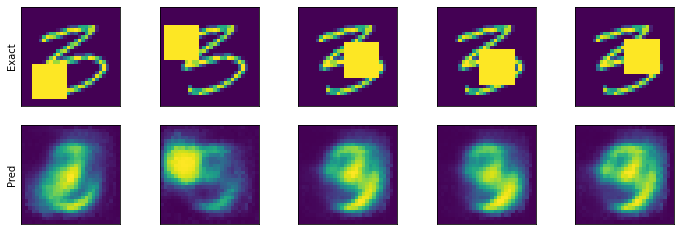

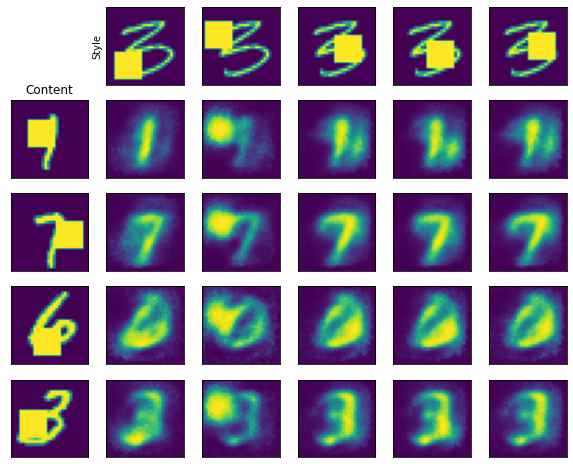

	mean loss    = 1554.400
	mse          = 1.625e+03
	KL           = 7.164e+02
	KL           = 2.550e+01
	dec_var      = 1.000e+00
epoch = 65.62s
Start of epoch 1
	mean loss    = 1554.837
	mse          = 1.131e+03
	KL           = 9.633e+02
	KL           = 2.625e+01
	dec_var      = 1.000e+00
epoch = 44.70s
Start of epoch 2
	mean loss    = 1837.616
	mse          = 1.048e+03
	KL           = 1.286e+03
	KL           = 2.762e+01
	dec_var      = 1.000e+00
epoch = 44.84s
Start of epoch 3
	mean loss    = 1862.476
	mse          = 9.429e+02
	KL           = 1.361e+03
	KL           = 3.007e+01
	dec_var      = 1.000e+00
epoch = 45.51s
Start of epoch 4
	mean loss    = 1786.108
	mse          = 8.507e+02
	KL           = 1.332e+03
	KL           = 2.909e+01
	dec_var      = 1.000e+00
epoch = 44.44s
Start of epoch 5
=== TRN ===


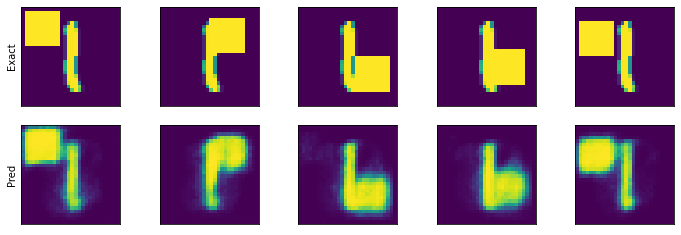

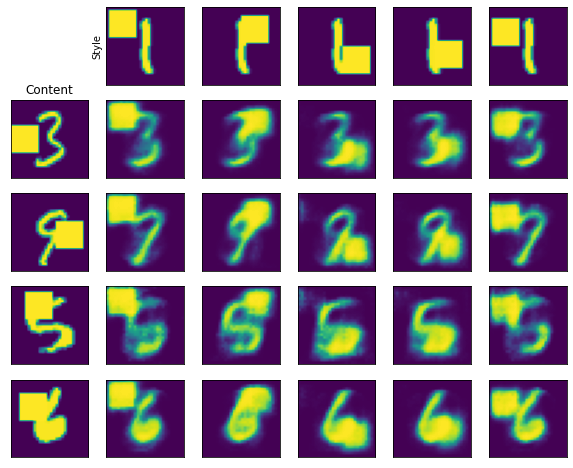

	mean loss    = 1833.618
	mse          = 8.177e+02
	KL           = 1.394e+03
	KL           = 3.123e+01
	dec_var      = 1.000e+00
epoch = 49.73s
Start of epoch 6
	mean loss    = 1879.438
	mse          = 7.745e+02
	KL           = 1.461e+03
	KL           = 3.103e+01
	dec_var      = 1.000e+00
epoch = 44.89s
Start of epoch 7
	mean loss    = 1791.377
	mse          = 7.621e+02
	KL           = 1.380e+03
	KL           = 3.047e+01
	dec_var      = 1.000e+00
epoch = 44.61s
Start of epoch 8
	mean loss    = 1506.424
	mse          = 7.113e+02
	KL           = 1.119e+03
	KL           = 3.155e+01
	dec_var      = 1.000e+00
epoch = 47.86s
Start of epoch 9
	mean loss    = 1466.308
	mse          = 6.960e+02
	KL           = 1.087e+03
	KL           = 3.153e+01
	dec_var      = 1.000e+00
epoch = 46.63s
Start of epoch 10
=== TRN ===


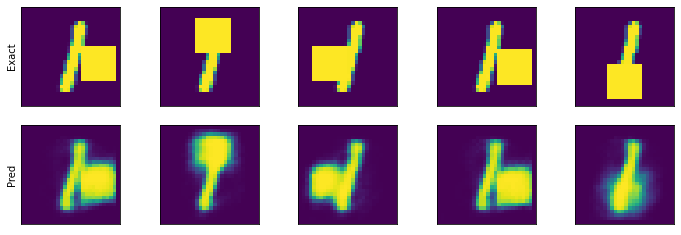

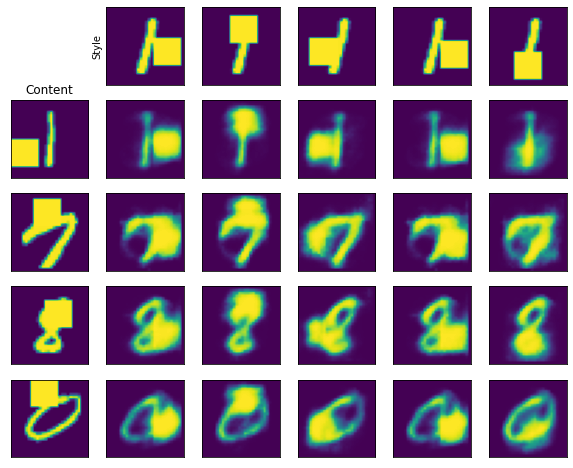

	mean loss    = 1435.472
	mse          = 6.857e+02
	KL           = 1.061e+03
	KL           = 3.173e+01
	dec_var      = 1.000e+00
epoch = 46.70s
Start of epoch 11
	mean loss    = 1349.300
	mse          = 6.803e+02
	KL           = 9.767e+02
	KL           = 3.248e+01
	dec_var      = 1.000e+00
epoch = 44.65s
Start of epoch 12
	mean loss    = 1359.503
	mse          = 6.873e+02
	KL           = 9.835e+02
	KL           = 3.232e+01
	dec_var      = 1.000e+00
epoch = 45.26s
Start of epoch 13
	mean loss    = 1289.190
	mse          = 6.883e+02
	KL           = 9.123e+02
	KL           = 3.279e+01
	dec_var      = 1.000e+00
epoch = 45.46s
Start of epoch 14
	mean loss    = 1214.379
	mse          = 6.847e+02
	KL           = 8.390e+02
	KL           = 3.306e+01
	dec_var      = 1.000e+00
epoch = 44.72s
Start of epoch 15
=== TRN ===


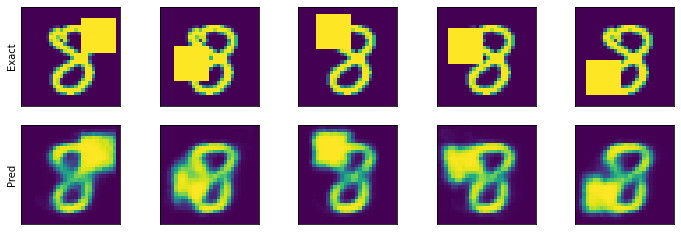

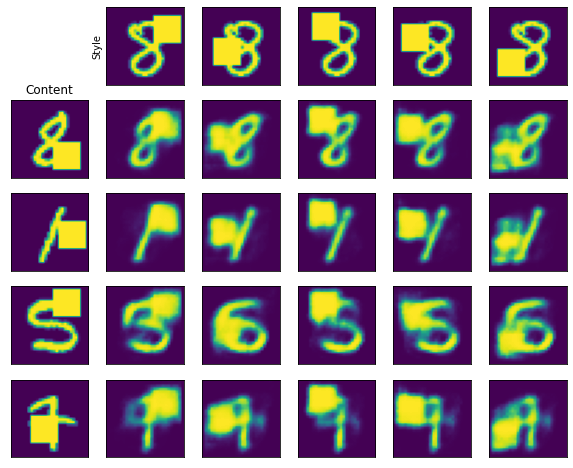

	mean loss    = 1173.777
	mse          = 6.704e+02
	KL           = 8.064e+02
	KL           = 3.215e+01
	dec_var      = 1.000e+00
epoch = 45.89s
Start of epoch 16
	mean loss    = 1346.729
	mse          = 6.873e+02
	KL           = 9.685e+02
	KL           = 3.462e+01
	dec_var      = 1.000e+00
epoch = 45.02s
Start of epoch 17
	mean loss    = 1346.671
	mse          = 6.203e+02
	KL           = 1.002e+03
	KL           = 3.411e+01
	dec_var      = 1.000e+00
epoch = 42.90s
Start of epoch 18
	mean loss    = 1235.473
	mse          = 6.177e+02
	KL           = 8.936e+02
	KL           = 3.303e+01
	dec_var      = 1.000e+00
epoch = 44.71s
Start of epoch 19
	mean loss    = 1448.474
	mse          = 6.607e+02
	KL           = 1.084e+03
	KL           = 3.384e+01
	dec_var      = 1.000e+00
epoch = 44.16s
Start of epoch 20
=== TRN ===


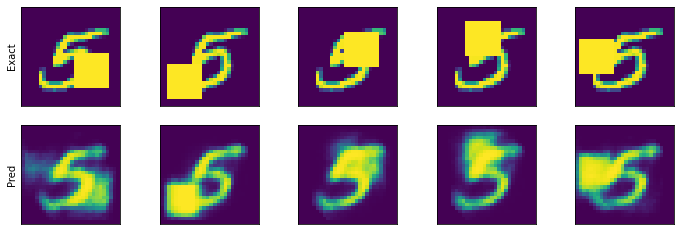

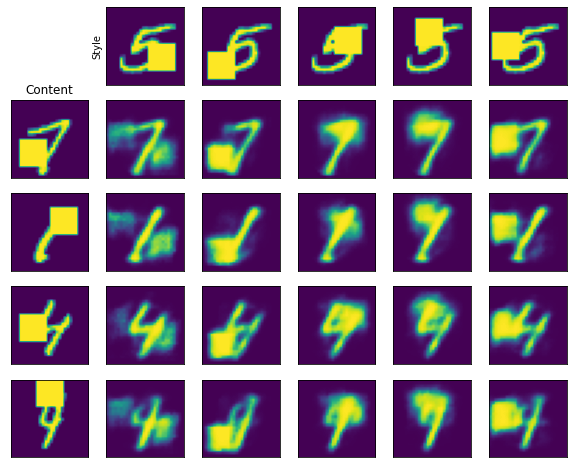

	mean loss    = 1480.754
	mse          = 6.817e+02
	KL           = 1.106e+03
	KL           = 3.375e+01
	dec_var      = 1.000e+00
epoch = 45.61s
Start of epoch 21
	mean loss    = 1523.624
	mse          = 6.941e+02
	KL           = 1.142e+03
	KL           = 3.466e+01
	dec_var      = 1.000e+00
epoch = 44.31s
Start of epoch 22
	mean loss    = 1650.497
	mse          = 7.043e+02
	KL           = 1.264e+03
	KL           = 3.442e+01
	dec_var      = 1.000e+00
epoch = 44.08s
Start of epoch 23
	mean loss    = 1744.770
	mse          = 7.080e+02
	KL           = 1.357e+03
	KL           = 3.399e+01
	dec_var      = 1.000e+00
epoch = 45.93s
Start of epoch 24
	mean loss    = 1350.033
	mse          = 5.980e+02
	KL           = 1.018e+03
	KL           = 3.309e+01
	dec_var      = 1.000e+00
epoch = 44.95s
Start of epoch 25
=== TRN ===


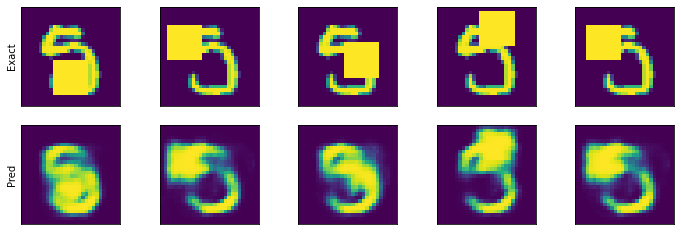

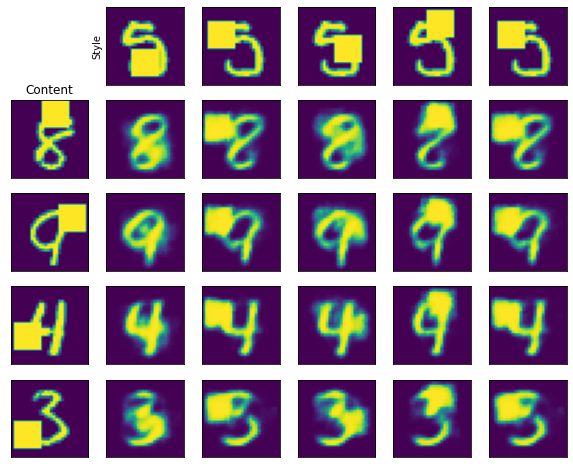

	mean loss    = 1238.563
	mse          = 5.491e+02
	KL           = 9.307e+02
	KL           = 3.328e+01
	dec_var      = 1.000e+00
epoch = 47.21s
Start of epoch 26
	mean loss    = 1217.464
	mse          = 5.674e+02
	KL           = 8.997e+02
	KL           = 3.408e+01
	dec_var      = 1.000e+00
epoch = 44.48s
Start of epoch 27
	mean loss    = 1201.634
	mse          = 5.540e+02
	KL           = 8.903e+02
	KL           = 3.439e+01
	dec_var      = 1.000e+00
epoch = 43.55s
Start of epoch 28
	mean loss    = 1241.163
	mse          = 5.778e+02
	KL           = 9.174e+02
	KL           = 3.487e+01
	dec_var      = 1.000e+00
epoch = 44.86s
Start of epoch 29
	mean loss    = 1405.572
	mse          = 6.266e+02
	KL           = 1.058e+03
	KL           = 3.443e+01
	dec_var      = 1.000e+00
epoch = 45.15s
Start of epoch 30
=== TRN ===


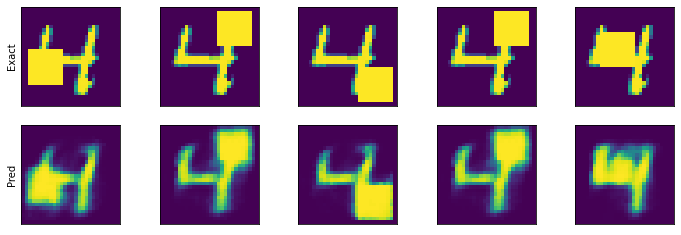

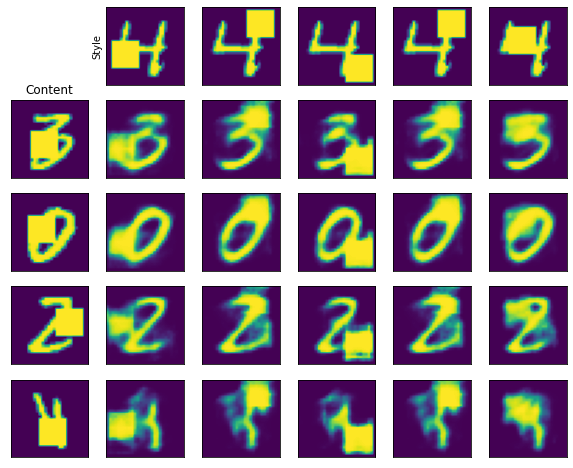

	mean loss    = 1199.817
	mse          = 5.608e+02
	KL           = 8.856e+02
	KL           = 3.385e+01
	dec_var      = 1.000e+00
epoch = 46.90s
Start of epoch 31
	mean loss    = 1104.235
	mse          = 5.133e+02
	KL           = 8.137e+02
	KL           = 3.392e+01
	dec_var      = 1.000e+00
epoch = 45.42s
Start of epoch 32
	mean loss    = 1244.911
	mse          = 5.551e+02
	KL           = 9.327e+02
	KL           = 3.471e+01
	dec_var      = 1.000e+00
epoch = 45.71s
Start of epoch 33
	mean loss    = 1217.873
	mse          = 5.501e+02
	KL           = 9.086e+02
	KL           = 3.428e+01
	dec_var      = 1.000e+00
epoch = 44.54s
Start of epoch 34
	mean loss    = 1146.604
	mse          = 5.234e+02
	KL           = 8.506e+02
	KL           = 3.431e+01
	dec_var      = 1.000e+00
epoch = 44.64s
Start of epoch 35
=== TRN ===


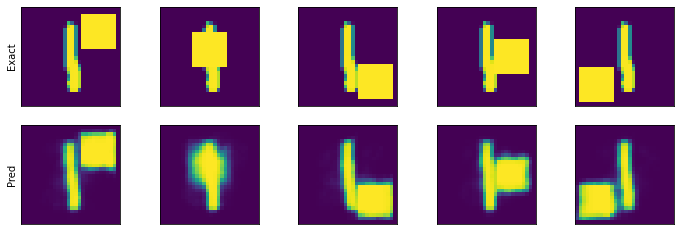

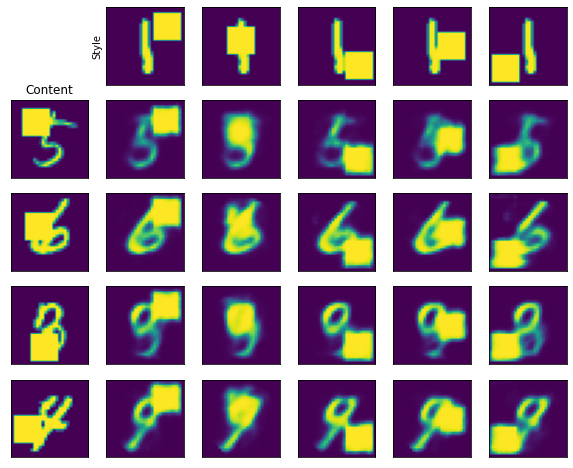

	mean loss    = 1152.938
	mse          = 5.415e+02
	KL           = 8.479e+02
	KL           = 3.431e+01
	dec_var      = 1.000e+00
epoch = 47.47s
Start of epoch 36
	mean loss    = 1197.083
	mse          = 5.671e+02
	KL           = 8.774e+02
	KL           = 3.612e+01
	dec_var      = 1.000e+00
epoch = 44.65s
Start of epoch 37
	mean loss    = 1125.977
	mse          = 5.300e+02
	KL           = 8.265e+02
	KL           = 3.444e+01
	dec_var      = 1.000e+00
epoch = 44.18s
Start of epoch 38
	mean loss    = 1103.896
	mse          = 5.340e+02
	KL           = 8.025e+02
	KL           = 3.438e+01
	dec_var      = 1.000e+00
epoch = 44.77s
Start of epoch 39
	mean loss    = 1599.526
	mse          = 6.082e+02
	KL           = 1.259e+03
	KL           = 3.636e+01
	dec_var      = 1.000e+00
epoch = 45.46s
Start of epoch 40
=== TRN ===


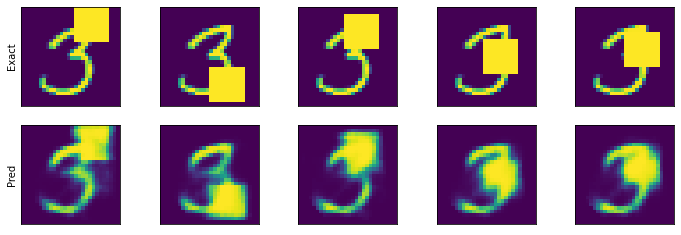

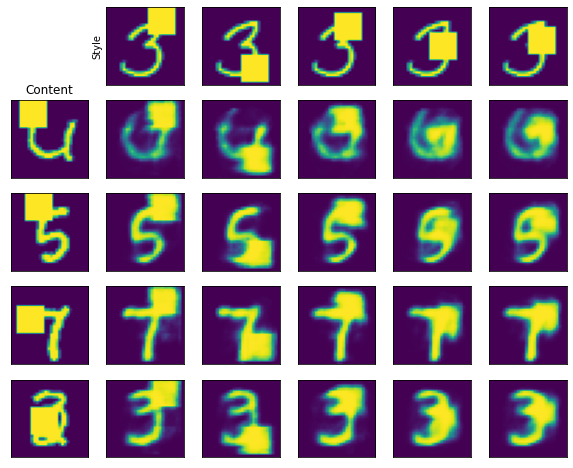

	mean loss    = 1401.054
	mse          = 5.711e+02
	KL           = 1.081e+03
	KL           = 3.435e+01
	dec_var      = 1.000e+00
epoch = 46.25s
Start of epoch 41
	mean loss    = 1299.691
	mse          = 5.906e+02
	KL           = 9.694e+02
	KL           = 3.493e+01
	dec_var      = 1.000e+00
epoch = 43.43s
Start of epoch 42
	mean loss    = 1379.231
	mse          = 6.019e+02
	KL           = 1.044e+03
	KL           = 3.461e+01
	dec_var      = 1.000e+00
epoch = 43.13s
Start of epoch 43
	mean loss    = 1256.887
	mse          = 5.588e+02
	KL           = 9.434e+02
	KL           = 3.408e+01
	dec_var      = 1.000e+00
epoch = 44.72s
Start of epoch 44
	mean loss    = 1212.735
	mse          = 5.396e+02
	KL           = 9.082e+02
	KL           = 3.472e+01
	dec_var      = 1.000e+00
epoch = 44.52s
Start of epoch 45
=== TRN ===


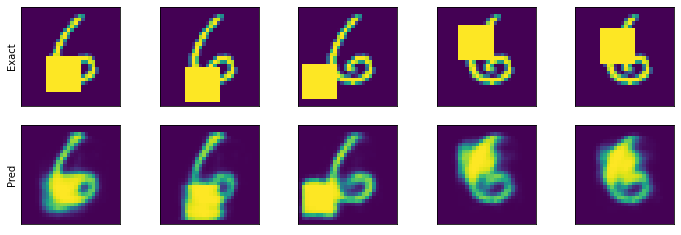

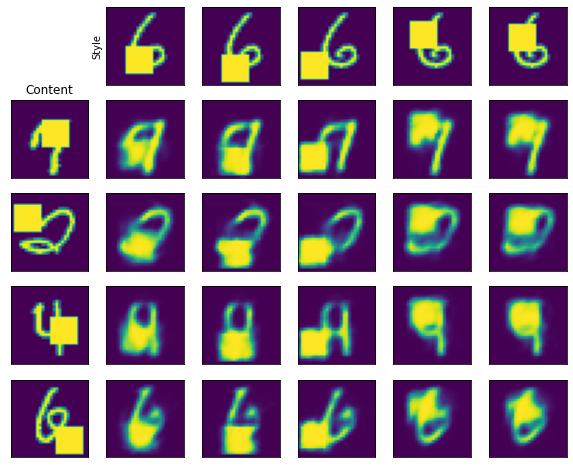

	mean loss    = 1283.422
	mse          = 5.518e+02
	KL           = 9.728e+02
	KL           = 3.476e+01
	dec_var      = 1.000e+00
epoch = 46.44s
Start of epoch 46
	mean loss    = 1165.249
	mse          = 5.159e+02
	KL           = 8.727e+02
	KL           = 3.457e+01
	dec_var      = 1.000e+00
epoch = 45.36s
Start of epoch 47
	mean loss    = 1310.637
	mse          = 5.700e+02
	KL           = 9.898e+02
	KL           = 3.581e+01
	dec_var      = 1.000e+00
epoch = 45.02s
Start of epoch 48
	mean loss    = 1242.682
	mse          = 5.363e+02
	KL           = 9.391e+02
	KL           = 3.538e+01
	dec_var      = 1.000e+00
epoch = 43.90s
Start of epoch 49
	mean loss    = 1118.764
	mse          = 4.873e+02
	KL           = 8.404e+02
	KL           = 3.472e+01
	dec_var      = 1.000e+00
epoch = 43.08s
Start of epoch 50
=== TRN ===


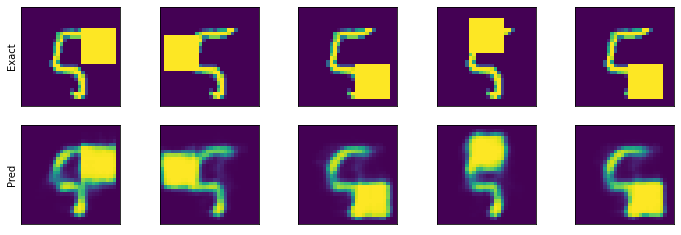

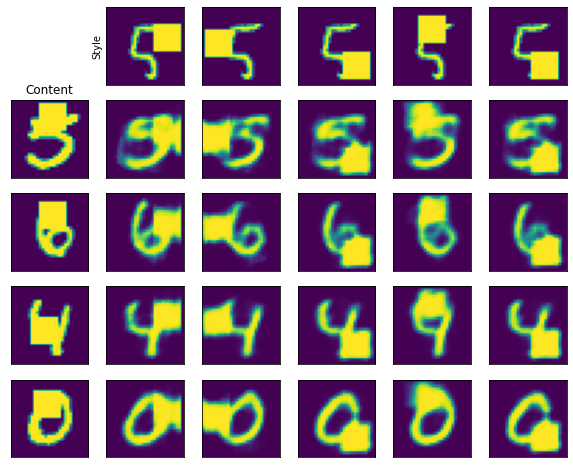

	mean loss    = 1077.226
	mse          = 4.841e+02
	KL           = 8.001e+02
	KL           = 3.510e+01
	dec_var      = 1.000e+00
epoch = 46.45s
Start of epoch 51
	mean loss    = 1170.023
	mse          = 5.113e+02
	KL           = 8.779e+02
	KL           = 3.642e+01
	dec_var      = 1.000e+00
epoch = 45.67s
Start of epoch 52
	mean loss    = 1418.409
	mse          = 5.548e+02
	KL           = 1.105e+03
	KL           = 3.598e+01
	dec_var      = 1.000e+00
epoch = 45.18s
Start of epoch 53
	mean loss    = 1326.809
	mse          = 5.503e+02
	KL           = 1.016e+03
	KL           = 3.527e+01
	dec_var      = 1.000e+00
epoch = 45.50s
Start of epoch 54
	mean loss    = 1250.810
	mse          = 5.429e+02
	KL           = 9.443e+02
	KL           = 3.505e+01
	dec_var      = 1.000e+00
epoch = 44.67s
Start of epoch 55
=== TRN ===


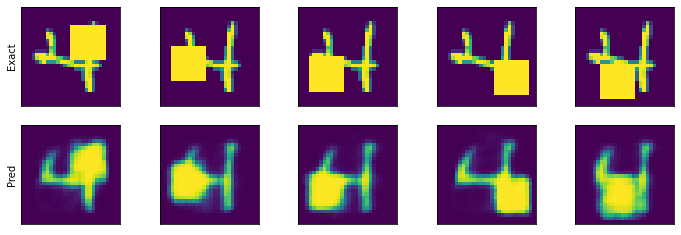

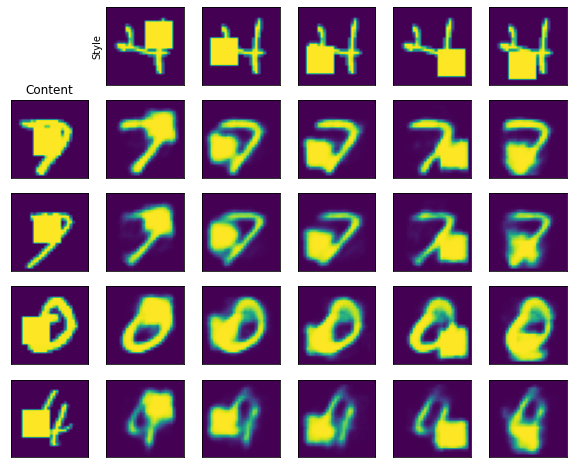

	mean loss    = 1236.097
	mse          = 5.549e+02
	KL           = 9.223e+02
	KL           = 3.638e+01
	dec_var      = 1.000e+00
epoch = 45.92s
Start of epoch 56
	mean loss    = 1261.835
	mse          = 5.710e+02
	KL           = 9.405e+02
	KL           = 3.588e+01
	dec_var      = 1.000e+00
epoch = 45.24s
Start of epoch 57
	mean loss    = 1384.582
	mse          = 5.521e+02
	KL           = 1.073e+03
	KL           = 3.560e+01
	dec_var      = 1.000e+00
epoch = 44.18s
Start of epoch 58
	mean loss    = 1211.447
	mse          = 4.963e+02
	KL           = 9.282e+02
	KL           = 3.512e+01
	dec_var      = 1.000e+00
epoch = 44.78s
Start of epoch 59
	mean loss    = 1149.640
	mse          = 4.771e+02
	KL           = 8.753e+02
	KL           = 3.577e+01
	dec_var      = 1.000e+00
epoch = 43.41s
Start of epoch 60
=== TRN ===


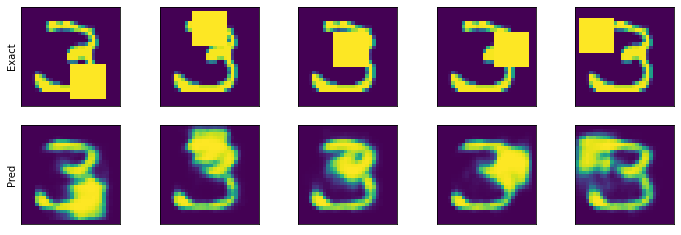

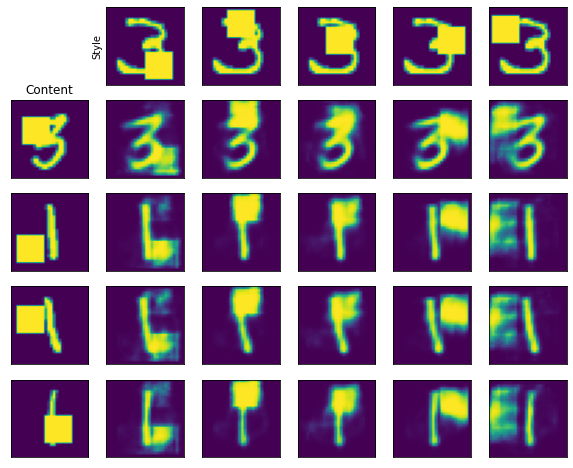

	mean loss    = 1376.011
	mse          = 5.444e+02
	KL           = 1.067e+03
	KL           = 3.666e+01
	dec_var      = 1.000e+00
epoch = 46.93s
Start of epoch 61
	mean loss    = 1384.146
	mse          = 5.581e+02
	KL           = 1.069e+03
	KL           = 3.627e+01
	dec_var      = 1.000e+00
epoch = 44.83s
Start of epoch 62
	mean loss    = 1244.588
	mse          = 5.296e+02
	KL           = 9.440e+02
	KL           = 3.582e+01
	dec_var      = 1.000e+00
epoch = 44.37s
Start of epoch 63
	mean loss    = 1271.748
	mse          = 5.251e+02
	KL           = 9.737e+02
	KL           = 3.550e+01
	dec_var      = 1.000e+00
epoch = 44.90s
Start of epoch 64
	mean loss    = 1168.889
	mse          = 5.093e+02
	KL           = 8.786e+02
	KL           = 3.562e+01
	dec_var      = 1.000e+00
epoch = 44.47s
Start of epoch 65
=== TRN ===


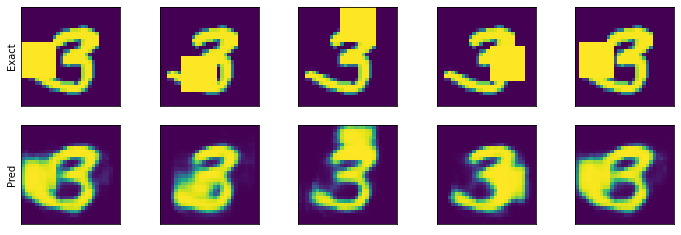

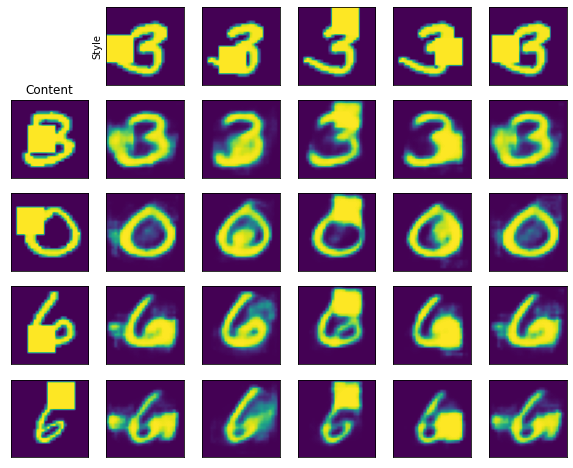

	mean loss    = 1112.432
	mse          = 4.858e+02
	KL           = 8.338e+02
	KL           = 3.577e+01
	dec_var      = 1.000e+00
epoch = 45.78s
Start of epoch 66
	mean loss    = 1222.838
	mse          = 5.116e+02
	KL           = 9.304e+02
	KL           = 3.667e+01
	dec_var      = 1.000e+00
epoch = 45.48s
Start of epoch 67
	mean loss    = 1153.781
	mse          = 4.777e+02
	KL           = 8.794e+02
	KL           = 3.554e+01
	dec_var      = 1.000e+00
epoch = 44.97s
Start of epoch 68
	mean loss    = 1118.976
	mse          = 5.012e+02
	KL           = 8.322e+02
	KL           = 3.616e+01
	dec_var      = 1.000e+00
epoch = 45.47s
Start of epoch 69
	mean loss    = 1194.117
	mse          = 5.640e+02
	KL           = 8.753e+02
	KL           = 3.677e+01
	dec_var      = 1.000e+00
epoch = 45.32s
Start of epoch 70
=== TRN ===


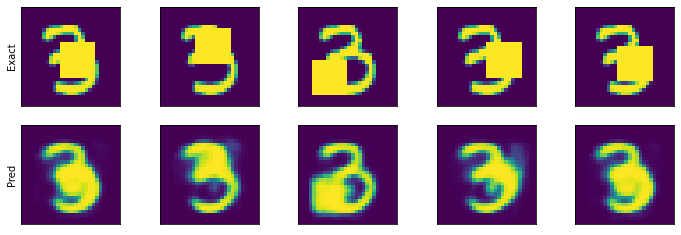

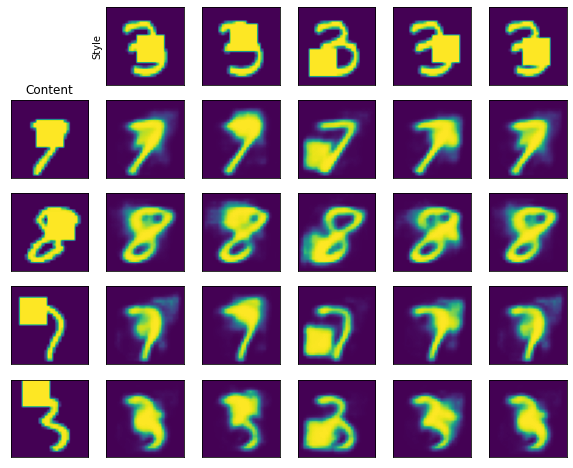

	mean loss    = 1364.917
	mse          = 6.160e+02
	KL           = 1.021e+03
	KL           = 3.573e+01
	dec_var      = 1.000e+00
epoch = 47.43s
Start of epoch 71
	mean loss    = 1403.498
	mse          = 6.316e+02
	KL           = 1.052e+03
	KL           = 3.565e+01
	dec_var      = 1.000e+00
epoch = 46.16s
Start of epoch 72
	mean loss    = 1274.320
	mse          = 5.916e+02
	KL           = 9.430e+02
	KL           = 3.550e+01
	dec_var      = 1.000e+00
epoch = 45.77s
Start of epoch 73
	mean loss    = 1186.396
	mse          = 5.686e+02
	KL           = 8.667e+02
	KL           = 3.542e+01
	dec_var      = 1.000e+00
epoch = 46.62s
Start of epoch 74
	mean loss    = 1115.003
	mse          = 5.306e+02
	KL           = 8.146e+02
	KL           = 3.516e+01
	dec_var      = 1.000e+00
epoch = 46.48s
Start of epoch 75
=== TRN ===


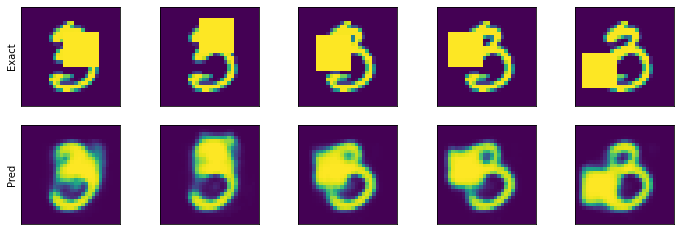

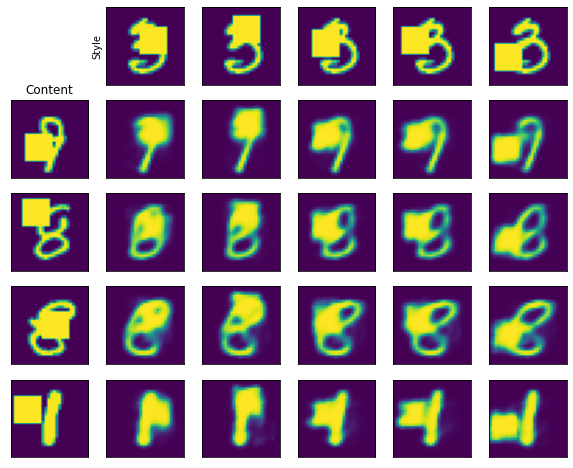

	mean loss    = 1065.206
	mse          = 5.026e+02
	KL           = 7.787e+02
	KL           = 3.525e+01
	dec_var      = 1.000e+00
epoch = 47.93s
Start of epoch 76
	mean loss    = 1098.130
	mse          = 5.296e+02
	KL           = 7.976e+02
	KL           = 3.573e+01
	dec_var      = 1.000e+00
epoch = 45.81s
Start of epoch 77
	mean loss    = 1197.781
	mse          = 6.143e+02
	KL           = 8.548e+02
	KL           = 3.587e+01
	dec_var      = 1.000e+00
epoch = 44.93s
Start of epoch 78
	mean loss    = 1286.200
	mse          = 6.778e+02
	KL           = 9.116e+02
	KL           = 3.566e+01
	dec_var      = 1.000e+00
epoch = 44.91s
Start of epoch 79
	mean loss    = 1258.480
	mse          = 6.435e+02
	KL           = 9.017e+02
	KL           = 3.499e+01
	dec_var      = 1.000e+00
epoch = 44.78s
Start of epoch 80
=== TRN ===


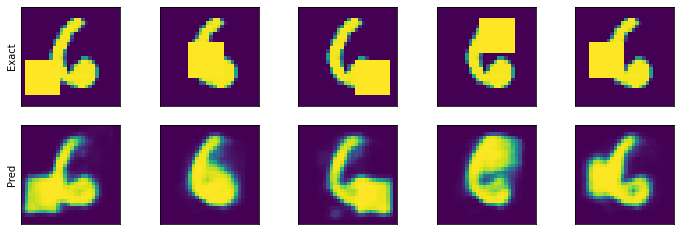

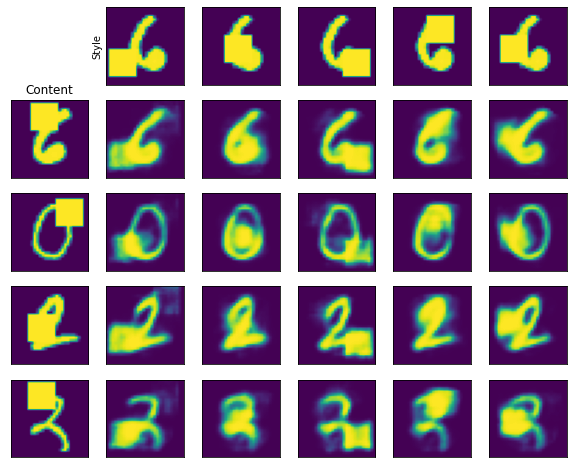

	mean loss    = 1206.310
	mse          = 5.952e+02
	KL           = 8.735e+02
	KL           = 3.521e+01
	dec_var      = 1.000e+00
epoch = 45.99s
Start of epoch 81
	mean loss    = 1236.205
	mse          = 5.673e+02
	KL           = 9.174e+02
	KL           = 3.515e+01
	dec_var      = 1.000e+00
epoch = 43.44s
Start of epoch 82
	mean loss    = 1453.809
	mse          = 6.036e+02
	KL           = 1.116e+03
	KL           = 3.622e+01
	dec_var      = 1.000e+00
epoch = 44.44s
Start of epoch 83
	mean loss    = 1284.458
	mse          = 5.422e+02
	KL           = 9.778e+02
	KL           = 3.555e+01
	dec_var      = 1.000e+00
epoch = 44.61s
Start of epoch 84
	mean loss    = 1187.213
	mse          = 4.962e+02
	KL           = 9.037e+02
	KL           = 3.538e+01
	dec_var      = 1.000e+00
epoch = 44.50s
Start of epoch 85
=== TRN ===


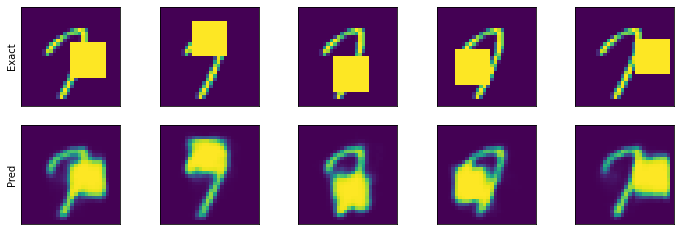

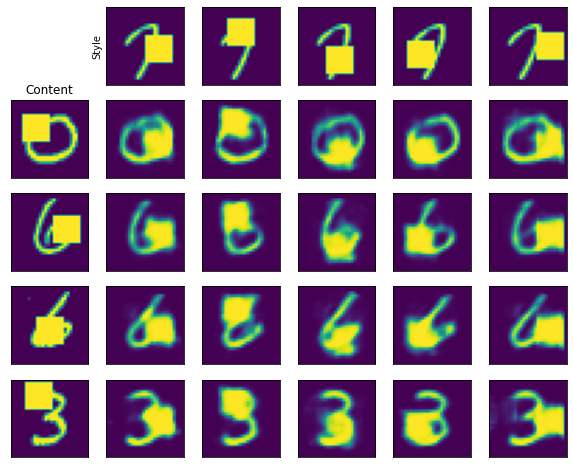

	mean loss    = 1131.432
	mse          = 4.713e+02
	KL           = 8.601e+02
	KL           = 3.569e+01
	dec_var      = 1.000e+00
epoch = 47.11s
Start of epoch 86
	mean loss    = 1188.861
	mse          = 5.008e+02
	KL           = 9.015e+02
	KL           = 3.695e+01
	dec_var      = 1.000e+00
epoch = 43.63s
Start of epoch 87
	mean loss    = 1286.391
	mse          = 5.237e+02
	KL           = 9.883e+02
	KL           = 3.629e+01
	dec_var      = 1.000e+00
epoch = 44.19s
Start of epoch 88
	mean loss    = 1236.238
	mse          = 5.243e+02
	KL           = 9.382e+02
	KL           = 3.593e+01
	dec_var      = 1.000e+00
epoch = 44.78s
Start of epoch 89
	mean loss    = 1157.319
	mse          = 4.840e+02
	KL           = 8.795e+02
	KL           = 3.576e+01
	dec_var      = 1.000e+00
epoch = 45.60s
Start of epoch 90
=== TRN ===


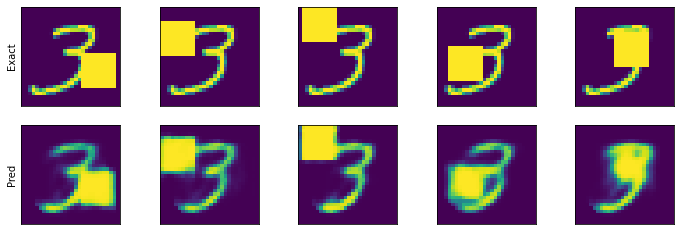

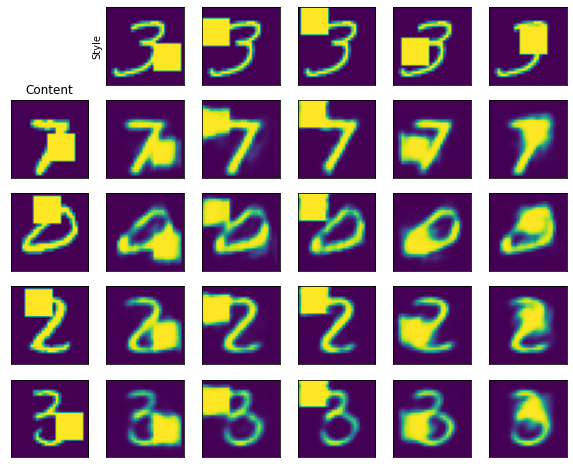

	mean loss    = 1132.390
	mse          = 4.757e+02
	KL           = 8.587e+02
	KL           = 3.588e+01
	dec_var      = 1.000e+00
epoch = 47.74s
Start of epoch 91
	mean loss    = 1131.160
	mse          = 4.781e+02
	KL           = 8.563e+02
	KL           = 3.584e+01
	dec_var      = 1.000e+00
epoch = 44.55s
Start of epoch 92
	mean loss    = 1106.856
	mse          = 4.747e+02
	KL           = 8.336e+02
	KL           = 3.592e+01
	dec_var      = 1.000e+00
epoch = 45.02s
Start of epoch 93
	mean loss    = 1175.192
	mse          = 4.967e+02
	KL           = 8.902e+02
	KL           = 3.669e+01
	dec_var      = 1.000e+00
epoch = 44.47s
Start of epoch 94
	mean loss    = 1141.566
	mse          = 4.728e+02
	KL           = 8.692e+02
	KL           = 3.603e+01
	dec_var      = 1.000e+00
epoch = 44.74s
Start of epoch 95
=== TRN ===


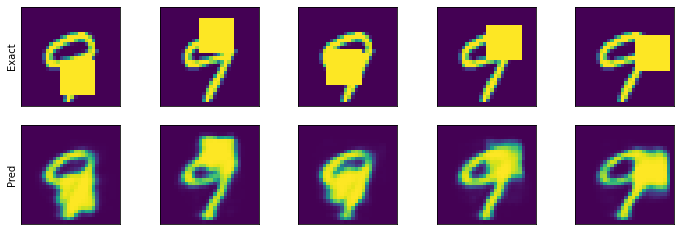

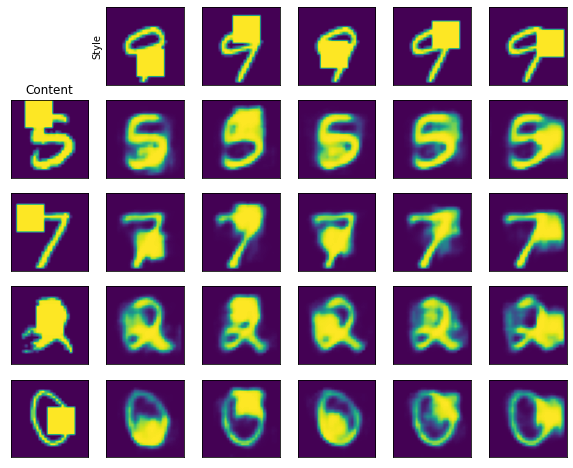

	mean loss    = 1152.062
	mse          = 4.730e+02
	KL           = 8.795e+02
	KL           = 3.612e+01
	dec_var      = 1.000e+00
epoch = 46.09s
Start of epoch 96
	mean loss    = 1158.785
	mse          = 4.755e+02
	KL           = 8.851e+02
	KL           = 3.597e+01
	dec_var      = 1.000e+00
epoch = 43.09s
Start of epoch 97
	mean loss    = 1123.844
	mse          = 4.674e+02
	KL           = 8.544e+02
	KL           = 3.572e+01
	dec_var      = 1.000e+00
epoch = 44.55s
Start of epoch 98
	mean loss    = 1124.719
	mse          = 4.963e+02
	KL           = 8.403e+02
	KL           = 3.632e+01
	dec_var      = 1.000e+00
epoch = 46.01s
Start of epoch 99
	mean loss    = 1112.746
	mse          = 4.915e+02
	KL           = 8.309e+02
	KL           = 3.611e+01
	dec_var      = 1.000e+00
epoch = 45.35s
Start of epoch 100
=== TRN ===


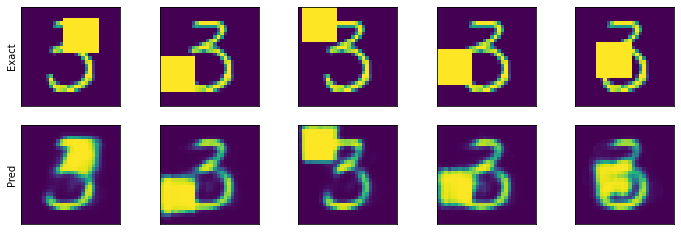

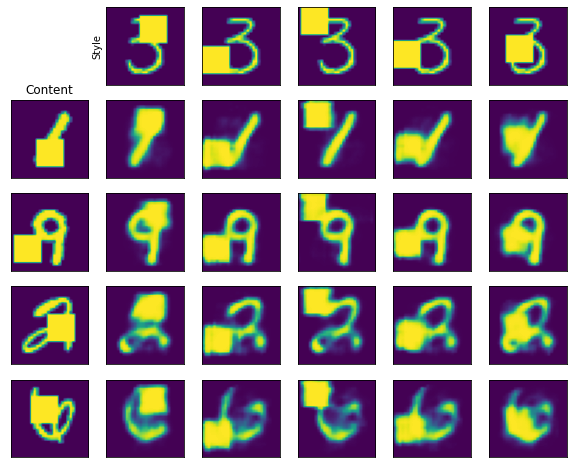

	mean loss    = 1083.904
	mse          = 4.831e+02
	KL           = 8.066e+02
	KL           = 3.579e+01
	dec_var      = 1.000e+00
epoch = 46.06s


In [7]:
# Iterate over epochs.
num_epochs = 101

for epoch in range(num_epochs):
#     display.clear_output(wait=False)
    print('===================', flush=True)
    print('Start of epoch %d' % (epoch,))
    start_time = time.perf_counter()
         
    for step, trn_batch in enumerate(trn_dist_dataset):
        _ = distributed_train_step(trn_batch)
            
    if epoch % 5 == 0:
        print('=== TRN ===')
#         if strategy.num_replicas_in_sync > 1:
#             # grab only batch assigned to first GPU
#             trn_batch = [x.values[0].numpy() for x in trn_batch]
#         else:
#             trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = trn_batch.numpy()

        trn_batch = trn_batch.values[0].numpy()
        """ plot decoding of replicates """
        pred = symvae.encode_decode(trn_batch)
#         se = (pred - trn_batch[0])**2 # squared error
        
        pred = pred.numpy()
        
        plt.figure(figsize=(12,4), facecolor='w')
        num_instance_plot = min([5, NUM_INSTANCES])
        for kk in np.arange(num_instance_plot):
            plt.subplot(2, num_instance_plot, kk+1)
            plt.imshow(trn_batch[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Exact')
                    
            plt.subplot(2, num_instance_plot, num_instance_plot+kk+1)
            plt.imshow(pred[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Pred')
            
        plt.show()
        
        """ plot styling of replicates """
        nsplot = 5 # number of style plots

        content_code = symvae.content_encode(trn_batch).numpy()
        style_code = symvae.style_encode(trn_batch).numpy()
        
        plt.figure(figsize=(10,10), facecolor='w')
        for jj in np.arange(nsplot):
            styled_mean = symvae.style_decode(content_code[[jj],:,:], style_code[[0],:,:])
            styled_mean = styled_mean.numpy()
            for kk in np.arange(nsplot):
                if jj == 0:
                    # plot the style of each instance inside the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, kk+2)
                    plt.imshow(trn_batch[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    if kk==0:
                        plt.ylabel('Style')
                else:
                    if kk==0:
                        # plot an instance to show the "content"
                        plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+1)
                        plt.imshow(trn_batch[jj,0,:].reshape(28,28))
                        plt.xticks([]); plt.yticks([]);
                        if jj == 1:
                            plt.title('Content')

                    # style the jth bag with styles from the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+2)
                    plt.imshow(styled_mean[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    
        plt.show()
    
    print('\tmean loss    = %.3f' % trn_loss_metric.result().numpy())
    print('\tmse          = %.3e' % trn_mse_metric.result().numpy())
    print('\tKL           = %.3e' % trn_sty_KL_metric.result().numpy())
    print('\tKL           = %.3e' % trn_cnt_KL_metric.result().numpy())
    print('\tdec_var      = %.3e' % symvae.decoder.dec_var.numpy())
    trn_loss_metric.reset_states()
    trn_mse_metric.reset_states()
    trn_sty_KL_metric.reset_states()
    trn_cnt_KL_metric.reset_states()
    
    print('epoch = %.2fs' % (time.perf_counter()-start_time))

In [8]:
# # https://www.tensorflow.org/guide/keras/save_and_serialize#hdf5_format
symvae.save_weights('symvae-masked-mnist-p0_2.h5')

ValueError: Unable to create group (name already exists)

### Load Model

In [9]:
# define model
style_dim = 20
content_dim = 20
data_dim = 28*28
mask_rate = 0.2
ninstances = NUM_INSTANCES

symvae = SYMVAE(data_dim, style_dim, content_dim, mask_rate, dec_var_model='fixed')

# call with dummy input to initialize dimensions
symvae(np.zeros((1,NUM_INSTANCES,28*28), dtype='float32'))

symvae.load_weights('symvae-masked-mnist-p0_9.h5')

OSError: Unable to open file (unable to open file: name = 'symvae-masked-mnist-p0_9.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)